In [ ]:
#imports
import os
import pandas as pd

In [ ]:
#Confirm access to a GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9b55ef55-9e4b-d4d7-c457-6f42650b4a79)


In [ ]:
#Get the dataset (Found here : https://github.com/Franck-Dernoncourt/pubmed-rct)

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#Check what files there are in pubmed-20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
#Start our experiment using the 20k dataset with numbers replaced by @ sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
#Check all the filenames in the target repo
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
#Preprocess the data (Visualize he data a bit)
#Function to read in all the lines of a target text file

def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
#Lets read the train lines
train_lines = get_lines(filenames[2])
train_lines[:20], len(train_lines)

(['###24290286\n',
  'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
  'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
  'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
  'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
  'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
  'RESULTS\tSixty-five patients were rando

Lets preprocess the data now and change it to how we want...

So lets create a list of dictionaries to seperate labels from the input sentences...

```
[{'line_number': 0,
  'target' : 'BACKGROUND',
  'text' : 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines' : 11},
  ...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename) #get all lines from filenames
  abstract_lines = '' #Create an empty abstract 
  abstract_samples = [] #Create an empty list of abstracts

  for line in input_lines:
    if line.startswith("###"): #Check to see if this is an ID line
      abstract_id = line
      abstract_lines = '' #reset the abstract string if the line is an ID line

    elif line.isspace(): #Check if line is a newline
      abstract_line_split = abstract_lines.splitlines() #split abstract into seperate lines

      #Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #Create an empty dict for each line
        target_text_split = abstract_line.split("\t") #Split label from text

        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split)-1
        abstract_samples.append(line_data)

    else: #if the above conditions arent fulfiled, the line contains labelled sentence
      abstract_lines+=line

  return abstract_samples

In [ ]:
#Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
print (len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 398 ms, sys: 90.9 ms, total: 489 ms
Wall time: 495 ms


In [ ]:
#Check the first abstract of our training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
#Visualise the data now
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
#Check out the distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

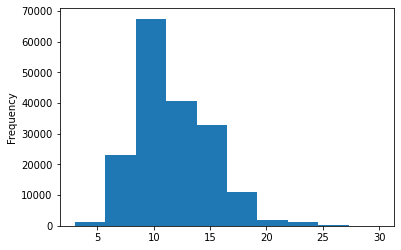

In [ ]:
#lets check the length of different lines
train_df.total_lines.plot.hist()

In [ ]:
#Get the list of text sentences and manipulate them
#Convert abstract tet lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
#Turning labels to a numeric form (ML models)
#One hot encoding
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

#Check one hot encoder looks like
train_labels_one_hot, val_labels_one_hot, test_labels_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [ ]:
#Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

#check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
#Get class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## MODEL-0 : Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create a pipeline
model_0 = Pipeline([
                    ('tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB()),
])

#Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
#Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
#Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-15 18:29:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-15 18:29:33 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##Prepare our data to input into deep models

In [ ]:
#Preparing out text data for deep sequence models (Vectorization and embeddings)

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
#How long is each sentence on an average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

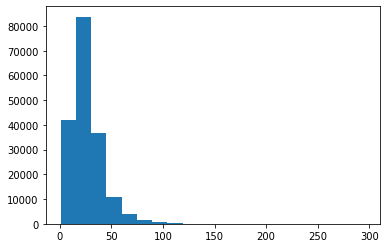

In [ ]:
#Whats the distribution look like

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [ ]:
# How long of a sentence length covers 95% of examples?

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Max sequence of length in the training set

max(sent_lens)

296

In [ ]:
#How many words are there in our vocabulary?
max_tokens = 68000

In [ ]:
#Create text vectorizer layer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
#test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print (f"Text : {target_sentence}")
print (f'\n Length of text : {len(target_sentence.split())}')
print (f'\n Vectorized text : {text_vectorizer([target_sentence])}')

Text : impacts were estimated separately for girls and boys using regression models .

 Length of text : 12

 Vectorized text : [[3136    9  597 2219   11 1747    3 1987   59  388  476    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
#How many words are there in training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print (f'Number of words in the vocab : {len(rct_20k_text_vocab)}')
print (f'Most commom words in the vocab : {rct_20k_text_vocab[:10]}')
print (f'Least common words in the vocab : {rct_20k_text_vocab[-5:]}')

Number of words in the vocab : 64841
Most commom words in the vocab : ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in the vocab : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
#Get the congif of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [ ]:
# Create a text embedding layer

token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                        output_dim = 128,
                                        mask_zero=True,
                                        name = 'token_embedding')

In [ ]:
#Show an example embedding
print (f'Sentence before vectorization : {target_sentence}')
vectorized_sentence = text_vectorizer([target_sentence])
print (f'Sentence after vectorization and before embedding : {vectorized_sentence}')
embedded_sentence = token_embed(vectorized_sentence)
print (f'Sentence after embedding : {embedded_sentence}')
print (f'Shape of embedded sentence : {embedded_sentence.shape}')

Sentence before vectorization : impacts were estimated separately for girls and boys using regression models .
Sentence after vectorization and before embedding : [[3136    9  597 2219   11 1747    3 1987   59  388  476    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Sentence after embedding : [[[ 0.01598999 -0.03979642  0.04746825 ...  0.00735195  0.02885369
    0.03774622]
  [ 0.01604355  0.0231698  -0.02226216 ... -0.01178727 -0.03410046
    0.04170973]
  [-0.00725525  0.03632854 -0.02319889 ...  0.02383294  0.00501733
   -0.00325938]
  ...
  [-0.03857142  0.03810002 -0.02138739 ...  0.03379292 -0.013644
   -0.01340371]
  [-0.03857142  0.03810002 -0.02138739 ...  0.03379292 -0.013644
   -0.01340371]
  [-0.03857142  0.03810002 -0.02138739 ...  0.03379292 -0.013644
   -0.01340371]]]
Shape of embedded sentenc

In [ ]:
#Creating a fast loading datset with tf.data API

#Turn our data into tf datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
#Take the Tensorfow datasets and turn them into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model-1 : Conv 1D model using embeddings created using TensorFlow

In [ ]:
inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9201 - accuracy: 0.6401 - val_loss: 0.6882 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6581 - accuracy: 0.7575 - val_loss: 0.6301 - val_accuracy: 0.7749
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6164 - accuracy: 0.7774 - val_loss: 0.5962 - val_accuracy: 0.7839


In [ ]:
#Evaluate on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5961 - accuracy: 0.7868


[0.5960901975631714, 0.7867734432220459]

In [ ]:
#Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.6644887e-01, 1.6136386e-01, 6.2130339e-02, 2.8354540e-01,
         2.6511453e-02],
        [4.4268304e-01, 2.7013651e-01, 1.3709973e-02, 2.6441786e-01,
         9.0527469e-03],
        [1.3176958e-01, 7.2785080e-03, 1.9788044e-03, 8.5889959e-01,
         7.3505376e-05],
        ...,
        [6.0889970e-06, 5.9092365e-04, 6.2943698e-04, 2.7374449e-06,
         9.9877077e-01],
        [6.0630791e-02, 4.6401691e-01, 1.0303722e-01, 6.2333550e-02,
         3.0998155e-01],
        [1.4376731e-01, 7.1968633e-01, 4.1706387e-02, 4.0835746e-02,
         5.4004148e-02]], dtype=float32), (30212, 5))

In [ ]:
#Convert pred probs with classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.6773467496359,
 'precision': 0.7835662972840443,
 'recall': 0.786773467496359,
 'f1': 0.7843772538359347}

###Feature extraction with pretrained toke embeddings (Universal sentence encoder)

In [ ]:
#Download pretrained tf hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
#Test it on a random sentence
random_training_sentence = random.choice(train_sentences)
print (f'Random sentence : {random_training_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print (f'Sentence after embedding : {use_embedded_sentence[0][:30]}')
print (f'Length of sentence embedding : {len(use_embedded_sentence[0])}')

Random sentence : there was no statistically significant difference between the treatment groups in the sense of demographic and other baseline parameters .
Sentence after embedding : [ 0.00750706 -0.00332937 -0.04540281 -0.02244002  0.01172857 -0.06255248
  0.02399936 -0.02870103 -0.04338167  0.07470022  0.08021685  0.02499558
 -0.02437846  0.0376394  -0.04180653 -0.01532825 -0.06162568 -0.01248965
  0.0095115  -0.00425555  0.01182275  0.0798905  -0.07115777 -0.01468394
 -0.01348499  0.05539147  0.0282249   0.06265789  0.00487997 -0.05537259]
Length of sentence embedding : 512


##Model-2 : Conv1D with Universal sentence encoder

In [ ]:
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = 'relu')(pretrained_embedding)
output = layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, output, name='model_2_use_feature_extractor')

model_2.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_2.summary()

Model: "model_2_use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9149 - accuracy: 0.6491 - val_loss: 0.7979 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7693 - accuracy: 0.7011 - val_loss: 0.7554 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7527 - accuracy: 0.7120 - val_loss: 0.7391 - val_accuracy: 0.7154


In [ ]:
#Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7417 - accuracy: 0.7140


[0.741746723651886, 0.7140209078788757]

In [ ]:
#Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

(array([[4.1899866e-01, 3.6320287e-01, 2.8825393e-03, 2.0471631e-01,
         1.0199557e-02],
        [3.1926939e-01, 5.1589817e-01, 3.9875708e-03, 1.5689491e-01,
         3.9499491e-03],
        [2.4117826e-01, 1.2759823e-01, 1.7860312e-02, 5.7508439e-01,
         3.8278796e-02],
        ...,
        [2.0021051e-03, 6.8679699e-03, 4.8027024e-02, 8.4625150e-04,
         9.4225669e-01],
        [3.3956470e-03, 4.5837108e-02, 2.1321151e-01, 1.0581112e-03,
         7.3649764e-01],
        [1.6640417e-01, 2.6355675e-01, 5.0219434e-01, 8.5861469e-03,
         5.9258591e-02]], dtype=float32), (30212, 5))

In [ ]:
#Convert pred probs with classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.4020918840196,
 'precision': 0.7139953777131527,
 'recall': 0.7140209188401959,
 'f1': 0.7109804134751594}

##Model-3 : Conv1D with charecter level embeddings

###Create a charectr level tokenizer


In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
#Make function to split sentences into charecters
def split_chars(text):
  return " ".join(list(text))

#Test it on an random sentence
split_chars(random_training_sentence)

't h e r e   w a s   n o   s t a t i s t i c a l l y   s i g n i f i c a n t   d i f f e r e n c e   b e t w e e n   t h e   t r e a t m e n t   g r o u p s   i n   t h e   s e n s e   o f   d e m o g r a p h i c   a n d   o t h e r   b a s e l i n e   p a r a m e t e r s   .'

In [ ]:
#Split sequence level data into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
#Whats the average charecter length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

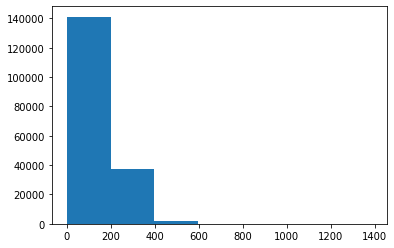

In [ ]:
#Check the distribution of our sequence at a character level
plt.hist(char_lens, bins=7)

In [ ]:
#Find what charecter legth covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
#Get all keyboard characters 
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#Create a char level vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #add two for space and UNK(unknown) tokens

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name='char_vectorizer')

In [ ]:
#Adapt character vectorizr to training charecters
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different charecters in charecter vocab : {len(char_vocab)}')
print(f'5 most common charecters : {char_vocab[:5]}')
print(f'5 Least used charecters : {char_vocab[-5:]}')

Number of different charecters in charecter vocab : 28
5 most common charecters : ['', '[UNK]', 'e', 't', 'i']
5 Least used charecters : ['k', 'x', 'z', 'q', 'j']


In [ ]:
#Test out the vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text : {random_train_chars}\n')
print(f'Length of random_train_chars : {len(random_train_chars.split())}\n')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'Vectorized Chars : {vectorized_chars}\n')
print(f'Length of vectorized chars : {len(vectorized_chars[0])}')

Charified text : p o s t o p e r a t i v e   i m a g i n g   c o n f i r m e d   t h e   c l e a r a n c e   o f   s u s p i c i o u s   n o d e s   i n   a l l   p a t i e n t s   .

Length of random_train_chars : 72

Vectorized Chars : [[14  7  9  3  7 14  2  8  5  3  4 21  2  4 15  5 18  4  6 18 11  7  6 17
   4  8 15  2 10  3 13  2 11 12  2  5  8  5  6 11  2  7 17  9 16  9 14  4
  11  4  7 16  9  6  7 10  2  9  4  6  5 12 12 14  5  3  4  2  6  3  9  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0

###Now create a character level embedding layer


In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim = 25,
                              mask_zero=True,
                              name='char_embed')

In [ ]:
#Test our charecter level embedding layer
print(f'Charified text : {random_train_chars}')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars after vectorization na embedding : {char_embed_example}')
print(f'Charecter embedding layer shape : {char_embed_example.shape}')

Charified text : p o s t o p e r a t i v e   i m a g i n g   c o n f i r m e d   t h e   c l e a r a n c e   o f   s u s p i c i o u s   n o d e s   i n   a l l   p a t i e n t s   .
Embedded chars after vectorization na embedding : [[[ 0.04271786  0.00941532 -0.04178888 ... -0.04840655  0.03763142
    0.04379186]
  [-0.03909127 -0.02090785  0.04419786 ...  0.04168506  0.03304828
    0.03661695]
  [-0.04620073 -0.04133523  0.02886338 ... -0.02207301  0.00234155
    0.02090803]
  ...
  [ 0.0413256  -0.03827338 -0.00412122 ... -0.01140099  0.02666591
   -0.04378694]
  [ 0.0413256  -0.03827338 -0.00412122 ... -0.01140099  0.02666591
   -0.04378694]
  [ 0.0413256  -0.03827338 -0.00412122 ... -0.01140099  0.02666591
   -0.04378694]]]
Charecter embedding layer shape : (1, 290, 25)
